<a href="https://colab.research.google.com/github/paolo0o0/Orders/blob/main/4task_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 4
**Линейная регрессия**

Загрузим все необходимые библиотеки и датасет load_diabetes

In [36]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

Загрузим матрицу признаков и вектор таргетов, как DataFrame, затем посмотрим на наши данные

In [37]:
X, y = datasets.load_diabetes(return_X_y=True, as_frame=True)
print(X.shape, y.shape)
X.head()

(442, 10) (442,)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [38]:
y.head()

0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
Name: target, dtype: float64

In [39]:
# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Этот набор данных содержит данные о пациентах с сахарным диабетом и содержит определенные характеристики, такие как их ИМТ, возраст, кровяное давление и уровень глюкозы, которые полезны для прогнозирования прогрессирования сахарного диабета у пациентов.


Используем алгоритм PCA для понижения размерности данных путём выявления главных компонент


In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_pca = X_train_pca.flatten()
X_test_pca = X_test_pca.flatten()
X_train_pca = pd.Series(X_train_pca)
X_test_pca = pd.Series(X_test_pca)
# Посмотрим теперь на размерность наших данных
print(X_train_pca.shape, X_test_pca.shape, y_train.dtype, X_train_pca.dtype)

(397,) (45,) float64 float64


Теперь реализуем собственный алгоритм линейной регрессии c функцией потерь MSE и MAE, чтобы затем сравнить их со стандартной реализацией из sklearn

В матричной форме, в случае, когда у нас есть $m$ объектов формулу можно переписать следующим образом:
$$ \vec{y} = X\vec{w}, $$ где $\vec{y}$ -- столбец размера $n$, $X$ --- матрица признаков размера $n \times k$ (каждая строка матрицы есть описание признаков объекта), $\vec{w}$ -- вектор весов размера $k$.

**Лосс:**
$$
\begin{aligned}
L(\vec{y}_{pred}, \vec{y}) &= \frac{1}{n}||\vec{y}_{pred} - \vec{y}||^2_2 =\\
&= \frac{1}{n}||X\vec{w} - \vec{y}||^2_2 = \frac{1}{n}\sum_{i=1}^{n}\left(\sum_{j=1}^{m} x_{ij}w_j - y_i\right)^2 =: L(w)
\end{aligned}
$$

Наша задача состоит в минимизации функции потерь.
$$
\begin{aligned}
\frac{\partial L}{\partial \vec{w}} = \frac{\partial}{\partial \vec{w}} \frac{1}{n} \left(\vec{y}^{T}\vec{y} - 2 \vec{y} X \vec{w} + \vec{w}^T X^T X \vec{w}\right) = \frac{1}{n} \left(-2 X^T \vec{y} + 2X^T X \vec{w} \right) = 0
\end{aligned}
$$
$$
\begin{aligned}
\frac{\partial L}{\partial \vec{w}} = 0 \iff
\end{aligned}
$$
$$
\begin{aligned}
\iff & \frac{1}{n}\left( -2X^T \vec{y} + 2X^T X \vec{w}\right) = 0  \iff
\end{aligned}
$$
$$
\begin{aligned}
\iff  -X^T \vec{y} +  X^T X \vec{w} = 0 \iff X^T X \vec{w} = X^T \vec{y} \iff  \vec{w} = (X^T X)^{-1} X^T \vec{y}
\end{aligned}
$$

Градиент $\vec{w}$:
$$
\frac{\partial{L}}{\partial{w}} = \frac{2}{n}(X^TX \vec{w} - X^T \vec{y}) = \frac{2}{n}X^T(\vec{y}_{pred} - \vec{y}) \,\,
$$

In [41]:
class MyLinearRegressionMSE:
    def __init__(self, fit_intercept=True):
        self.w = None
        self.fit_intercept = fit_intercept

    def predict(self, X):
        # Принимает на вход X и возвращает ответы модели
        # Не забудьте про фиктивный признак равный 1
        n, k = X.shape
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))

        y_pred = X_train @ self.w

        return y_pred

    def fit(self, X, y, lr=0.01, max_iter=500):
        # Принимает на вход X, y и вычисляет веса по данной выборке
        n, k = X.shape
        # Случайно инициализируем веса
        if self.w is None:
            self.w = np.random.randn(k + 1 if self.fit_intercept else k)

        X_train = np.hstack((X, np.ones((n, 1)))) if self.fit_intercept else X

        self.losses = []
        for iter_num in range(max_iter):
            y_pred = self.predict(X)

            self.losses.append(np.sum((y_pred - y) @ (y_pred - y).T))
            grad = self._calc_gradient(X_train, y, y_pred)
            self.w -= lr * grad
        return self

    def _calc_gradient(self, X, y, y_pred):
        grad = 2 * (y_pred - y)[:, np.newaxis] * X
        grad = grad.mean(axis=0)
        return grad

    def get_losses(self):
        return self.losses

    def get_weights(self):
        return self.w

Убедимся, что наш градиентный спуск работает правильно, построив график функции потерь в зависимости от номера итерации

In [42]:
regressor_MSE = MyLinearRegressionMSE()

l = regressor_MSE.fit(X_train_pca[:, np.newaxis], y_train, max_iter=500).get_losses()

predictions = regressor_MSE.predict(X_test_pca[:, np.newaxis])
w = regressor_MSE.get_weights()

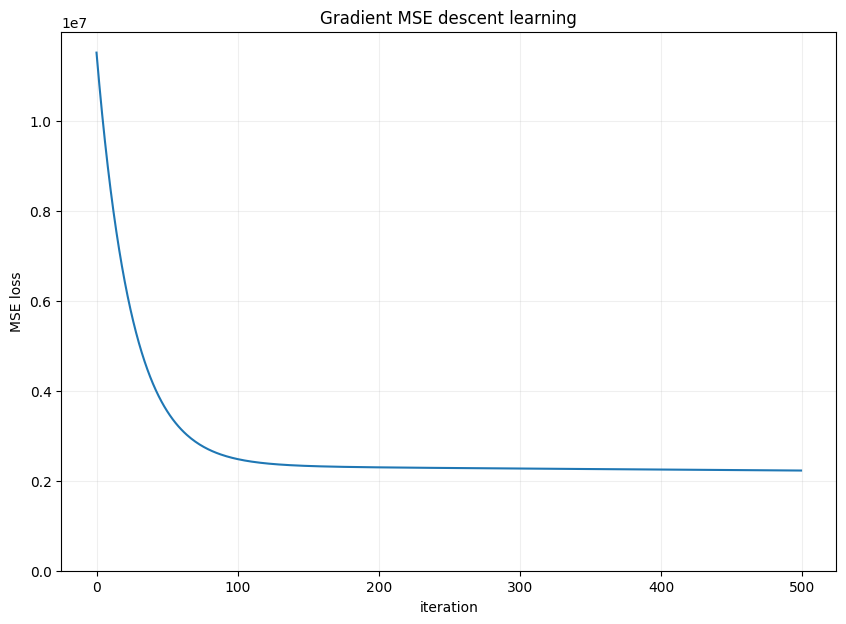

In [43]:
plt.figure(figsize=(10, 7))
plt.plot(l)

plt.title('Gradient MSE descent learning')
plt.ylabel('MSE loss')
plt.xlabel('iteration')
plt.ylim(bottom=0)
plt.grid(alpha=0.2)

plt.show()

Теперь реализуем алгоритм линейной регрессии с функцией потерь MAE

**Лосс:**
$$
\begin{aligned}
L(\vec{y}_{pred}, \vec{y}) = \frac{1}{n} ||\vec{y}_{pred} - \vec{y} ||_1 = \frac{1}{n}||X \vec{w} - \vec{y} ||_1
\end{aligned}
$$
Чтобы посчитать градиент функции потерь MAE по вектору весов, мы можем воспользоваться понятием субградиента, так как функция MAE не является дифференцируемой в некоторых точках. Субградиент MAE по вектору весов w можно определить следующим образом:
$$
\frac{\partial L}{\partial \ w_j} = \frac{1}{n} \sum_{i = 0}^n \frac{\partial |y_i - y_{ipred}|}{\partial w_j}
$$
где $\frac{\partial |y - y_{pred}|}{\partial w_j}$  - субдифференциал абсолютной разности.
Он принимает значения:
$$
\begin{aligned}
-1, \text{если} \ y - y_{pred} < 0 \\
0, \text{если} \ y - y_{pred} = 0 \\
1, \text{если} \ y - y_{pred} > 0
\end{aligned}
$$

In [44]:
class MyLinearRegressionMAE(MyLinearRegressionMSE):
    def __init__(self, **kwargs):
        super().__init__(**kwargs) # Передача именных параметров родительскому конструктору
        self.w = None

    def _calc_gradient(self, X, y, w):
        y = y.to_numpy()
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        if w.ndim == 1:
            w = w.reshape(-1, 1)

        diff = X.dot(w) - y

        return np.mean(np.where(diff == 0, 0, np.where(diff > 0, 1, -1)))

    def fit(self, X, y, lr=0.01, max_iter=500):
        # Принимает на вход X, y и вычисляет веса по данной выборке
        n, k = X.shape
        # Случайно инициализируем веса
        if self.w is None:
            self.w = np.random.randn(k + 1 if self.fit_intercept else k)

        X_train = np.hstack((X, np.ones((n, 1)))) if self.fit_intercept else X

        self.losses = []
        for iter_num in range(max_iter):
            y_pred = self.predict(X)

            self.losses.append(np.sum((y_pred - y) @ (y_pred - y).T))
            grad = self._calc_gradient(X_train, y, self.w)
            self.w -= lr * grad
        return self

Также построим график функции потерь для MAE линейной регрессии

In [45]:
regressor_MAE = MyLinearRegressionMAE()

l = regressor_MAE.fit(X_train_pca[:, np.newaxis], y_train, lr=0.1, max_iter=5000).get_losses()
predictions = regressor_MAE.predict(X_test_pca[:, np.newaxis])
w = regressor_MAE.get_weights()

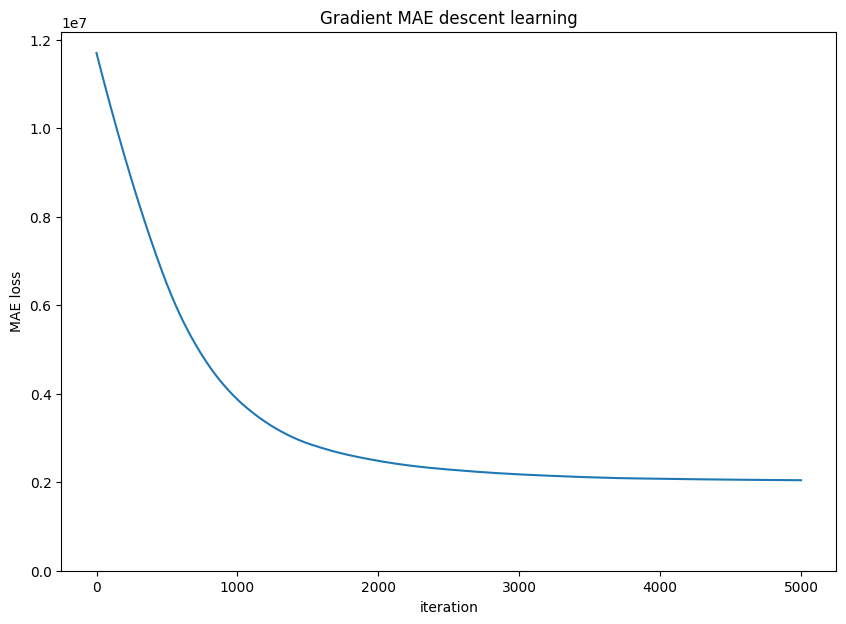

In [46]:
plt.figure(figsize=(10, 7))
plt.plot(l)

plt.title('Gradient MAE descent learning')
plt.ylabel('MAE loss')
plt.xlabel('iteration')
plt.ylim(bottom=0)

plt.show()

Импортируем стандартный алгоритм LinearRegression из sklearn

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_absolute_error, r2_score

# Обучим стандартную LinearRegression модель из sklearn,
# И 3 модели с нашей собственной реализацией
std_reg = LinearRegression().fit(X_train_pca[:, np.newaxis], y_train)
my_reg_mse = MyLinearRegressionMSE().fit(X_train_pca[:, np.newaxis], y_train)
my_reg_mae_short = MyLinearRegressionMAE().fit(X_train_pca[:, np.newaxis],
                                               y_train, lr=0.1, max_iter=500)
my_reg_mae_long = MyLinearRegressionMAE().fit(X_train_pca[:, np.newaxis],
                                              y_train, lr=0.1, max_iter=5000)

Теперь сравним основные метрики качества для собственной реализации и варианта из sklearn

**1. Mean squared error**

In [48]:
print(mean_squared_error(
    y_test, std_reg.predict(X_test_pca[:, np.newaxis])))
print(mean_squared_error(
    y_test, my_reg_mae_short.predict(X_test_pca[:, np.newaxis])))
print(mean_squared_error(
    y_test, my_reg_mae_long.predict(X_test_pca[:, np.newaxis])))
print(mean_squared_error(
    y_test, my_reg_mse.predict(X_test_pca[:, np.newaxis])))

3803.5376922288747
16048.313592598144
5197.523672443373
5788.03280557302


**2. Mean squared log error**

In [49]:
print(mean_squared_log_error(
    y_test, std_reg.predict(X_test_pca[:, np.newaxis])))
print(mean_squared_log_error(
    y_test, my_reg_mae_short.predict(X_test_pca[:, np.newaxis])))
print(mean_squared_log_error(
    y_test, my_reg_mae_long.predict(X_test_pca[:, np.newaxis])))
print(mean_squared_log_error(
    y_test, my_reg_mse.predict(X_test_pca[:, np.newaxis])))

0.21235446246340767
1.1304118654197668
0.24438801685934589
0.2968127500471621


**3. Root mean squared error**

In [50]:
print(mean_squared_error(y_test, std_reg.predict(
    X_test_pca[:, np.newaxis]), squared=False))
print(mean_squared_error(y_test, my_reg_mae_short.predict(
    X_test_pca[:, np.newaxis]), squared=False))
print(mean_squared_error(y_test, my_reg_mae_long.predict(
    X_test_pca[:, np.newaxis]), squared=False))
print(mean_squared_error(y_test, my_reg_mse.predict(
    X_test_pca[:, np.newaxis]), squared=False))

61.67282782740609
126.68193869924056
72.09385322233354
76.07912200842632


**4. Mean absolute error**

In [51]:
print(mean_absolute_error(
    y_test, std_reg.predict(X_test_pca[:, np.newaxis])))
print(mean_absolute_error(
    y_test, my_reg_mae_short.predict(X_test_pca[:, np.newaxis])))
print(mean_absolute_error(
    y_test, my_reg_mae_long.predict(X_test_pca[:, np.newaxis])))
print(mean_absolute_error(
    y_test, my_reg_mse.predict(X_test_pca[:, np.newaxis])))

50.975070178637495
102.0710100064128
59.38572509414172
65.8660338798892


**5. R2 score**

In [52]:
print(r2_score(
    y_test, std_reg.predict(X_test_pca[:, np.newaxis])))
print(r2_score(
    y_test, my_reg_mae_short.predict(X_test_pca[:, np.newaxis])))
print(r2_score(
    y_test, my_reg_mae_long.predict(X_test_pca[:, np.newaxis])))
print(r2_score(
    y_test, my_reg_mse.predict(X_test_pca[:, np.newaxis])))

0.37819031341193887
-1.6236092955431385
0.15029879356811005
0.053761220206095195


Видим, что наши модели значительно хуже справились с задачей, чем стандартная линейная регрессия из sklearn. Все метрики, посчитанные выше, это отражают. Также они показали, что из реализованных нами алгоритмов лучшего качества достигла MAE линейная регрессия с числом итераций = 5000. Заметим, что MAE линейная регрессия сходится намного медленнее, чем MSE. MAE регрессия за ~3000 итераций градиентного спуска достигает примерно того же качества, что и MSE с числом итераций = 100.

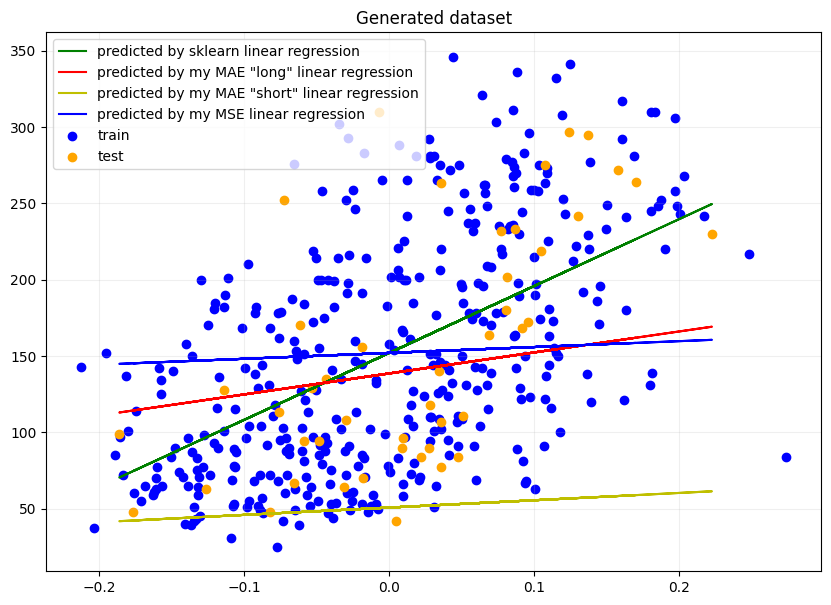

In [53]:
plt.figure(figsize=(10, 7))
plt.plot(X_test_pca, std_reg.predict(X_test_pca[:, np.newaxis]),
         label='predicted by sklearn linear regression', c='g')
plt.plot(X_test_pca, my_reg_mae_long.predict(X_test_pca[:, np.newaxis]),
         label='predicted by my MAE "long" linear regression', c='r')
plt.plot(X_test_pca, my_reg_mae_short.predict(X_test_pca[:, np.newaxis]),
         label='predicted by my MAE "short" linear regression', c='y')
plt.plot(X_test_pca, my_reg_mse.predict(X_test_pca[:, np.newaxis]),
         label='predicted by my MSE linear regression', c='b')

plt.scatter(X_train_pca, y_train, label='train', c='b')
plt.scatter(X_test_pca, y_test, label='test', c='orange')

plt.title("Generated dataset")
plt.grid(alpha=0.2)
plt.legend()
plt.show()

Посмотрев на график, можно понять, что данных недостаточно, чтобы обучить линейные модели, реализованные нами. Видно, как проявляется переобучение у наших моделей. Зелёная прямая, соответствующая стандартной реализации из sklearn отражает глобальную закономерность распределения данных. В то время как наша MSE реализация подстроилась под обучающую выборку, стараясь минимизировать квадраты ошибок.